In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import requests
#https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml

from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder

import numpy as np
import matplotlib.pyplot as plt

In [2]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

In [3]:
# Loads data
dataset = spark_session\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("data/data_file_2.csv",inferSchema = True)
#dataset = spark_session.read.format("libsvm").load("data/data_file.txt")

In [4]:
dataset.printSchema()
dataset.show()

root
 |-- label: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- adjClose: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- unadjustedVolume: double (nullable = true)
 |-- change: double (nullable = true)
 |-- changePercent: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- changeOverTime: double (nullable = true)

+----------+----------+----------+----------+----------+----------+----------------+--------+-------------+---------+--------------+
|     label|      high|       low|      open|  adjClose|    volume|unadjustedVolume|  change|changePercent|     vwap|changeOverTime|
+----------+----------+----------+----------+----------+----------+----------------+--------+-------------+---------+--------------+
|115.970001|117.589996|114.129997|115.550003|115.970001|1.380234E8|      1.380234E8|    0.42|        0.363|115.89666|       0.00363|
|    116.32|121.989998|116.

In [8]:
feature_list = []
for col in dataset.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
assembler

VectorAssembler_bf1950da8875

In [65]:
#lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr = LinearRegression(featuresCol = 'features', labelCol = 'label',)

In [66]:
# Now, we put our simple, two-stage workflow into an ML pipeline.
pipeline = Pipeline(stages=[assembler, lr])

In [71]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)]) \
    .addGrid(lr.regParam, [float(x) for x in np.linspace(start = 0.1, stop = 0.9, num = 4)]) \
    .addGrid(lr.elasticNetParam, [float(x) for x in np.linspace(start = 0.01, stop = 1.0, num = 6)]) \
    .build()
    #.addGrid(rf.maxBins, [int(x) for x in np.linspace(start = 32, stop = 64, num = 3)]) \
    

array([0.01 , 0.208, 0.406, 0.604, 0.802, 1.   ])

In [72]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [73]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+--------+
|   label|
+--------+
|0.115513|
|0.116629|
|0.117188|
|0.117188|
|0.117188|
| 0.12221|
| 0.12221|
| 0.12221|
|0.122768|
|0.123326|
+--------+
only showing top 10 rows

None


In [74]:
cvModel = crossval.fit(trainingData)

In [75]:
predictions = cvModel.transform(testData)

In [76]:
print(predictions.select("prediction", "label", "features").show(10))
print(trainingData.select("label").show(10))

+-------------------+--------+--------------------+
|         prediction|   label|            features|
+-------------------+--------+--------------------+
|0.21297639567194424|0.117746|[0.119978,0.11383...|
| 0.2135719303822059|0.117746|[0.125,0.117188,0...|
|0.21340234836358704|0.118304|[0.11942,0.113839...|
|0.21403878323393177|0.118862|[0.11942,0.116071...|
|0.21454888944751693|0.118862|[0.125,0.117746,0...|
|0.21854586346144228|0.123326|[0.125,0.122768,0...|
|0.22052179765580254|0.124442|[0.130022,0.12444...|
|0.22363257204961073|0.130022|[0.130022,0.12388...|
|0.22638677239898283|0.131138|[0.132254,0.13058...|
| 0.2319274407286128|0.136719|[0.138951,0.13616...|
+-------------------+--------+--------------------+
only showing top 10 rows

None
+--------+
|   label|
+--------+
|0.115513|
|0.116629|
|0.117188|
|0.117188|
|0.117188|
| 0.12221|
| 0.12221|
| 0.12221|
|0.122768|
|0.123326|
+--------+
only showing top 10 rows

None


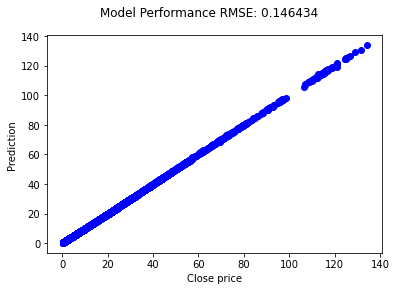

0.1464342266455872


In [77]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(dataset)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print(rmse)

In [78]:
rmse

0.1464342266455872

In [79]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

In [80]:
bestModel.getRegParam()

0.1

In [81]:
bestModel.getMaxIter()

30

In [82]:
bestModel.getElasticNetParam()

0.20800000000000002

In [83]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(bestModel.coefficients))
print("Intercept: %s" % str(bestModel.intercept))

Coefficients: [0.204803184364723,0.21440905525664603,0.21019993035140186,0.16063793330789808,0.0,0.0,0.41759790834496596,0.0,0.21105521408127448,0.0]
Intercept: 0.0978184165607052


In [84]:
# Summarize the model over the training set and print out some metrics
trainingSummary = bestModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

numIterations: 31
objectiveHistory: [0.49999999999999994, 0.3934927134582515, 0.00339508633262714, 0.0022602049206921684, 0.001433825136234035, 0.001433138513297557, 0.0014329390126146735, 0.0014327436488435878, 0.0014327000036116954, 0.0014302451312081213, 0.0014277568056076597, 0.0014277494398694237, 0.0014277423055484894, 0.0014277419925969558, 0.0014277419831935023, 0.0014277419625334028, 0.0014277419600158374, 0.0014277419558991434, 0.0014277419518478971, 0.0014277419477267714, 0.0014277419435672332, 0.0014277419395083823, 0.0014277419351985787, 0.00142774193115742, 0.0014277419270075445, 0.0014277419228730889, 0.0014277419200464667, 0.0014277419133773702, 0.0014277419108329398, 0.001427741904055243, 0.0014277419017669573]
+--------------------+
|           residuals|
+--------------------+
|-0.09600153491270327|
|-0.09566089831172968|
|-0.09561267320218965|
|-0.09517579300701269|
|-0.09614207902456125|
|-0.09503909367195583|
|-0.09486856958831212|
|-0.09535442932279319|
|-0.09549